In [1]:
import sys
sys.path.append(r'c:\Users\ice\projects\iris')

from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm

from iris.config.segmentation_pipeline_config_manager import SegmentationPipelineConfigManager
from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager
from iris.segmentation_pipeline.segmentation_handler import SegmentationHandler
from iris.utils.image_utils import load_image
from iris.utils.data_utils import display_image_summary

Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

Processing image: C:\Users\ice\projects\iris\data\dev\nikolaj_storm\images\cf01c8937b391ab760476f80f5cf3c4b_IMG_0652-500x700.jpg



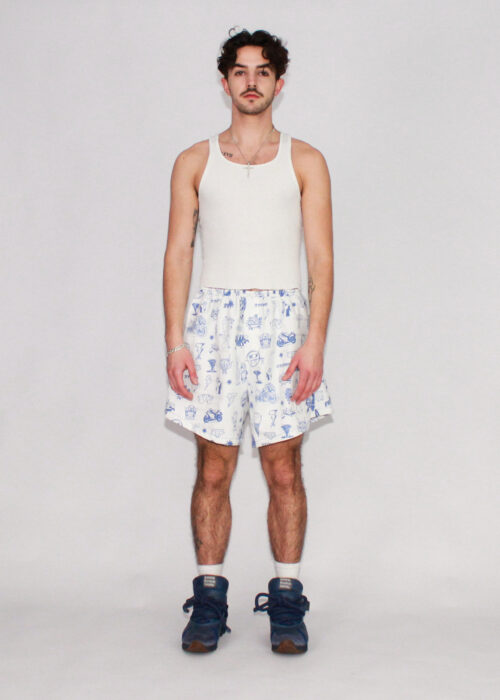
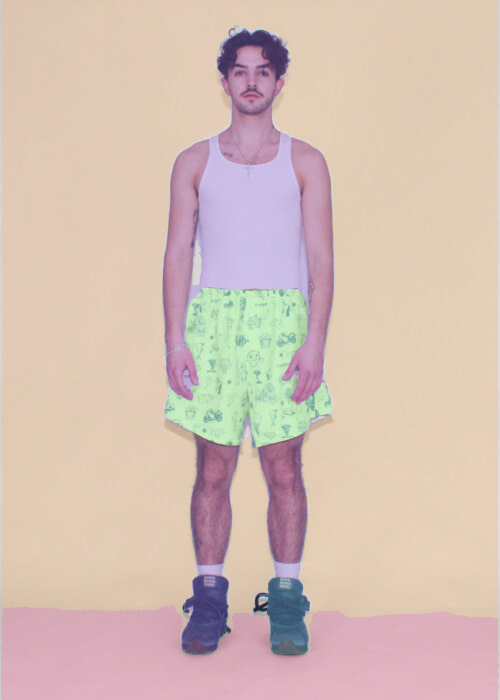
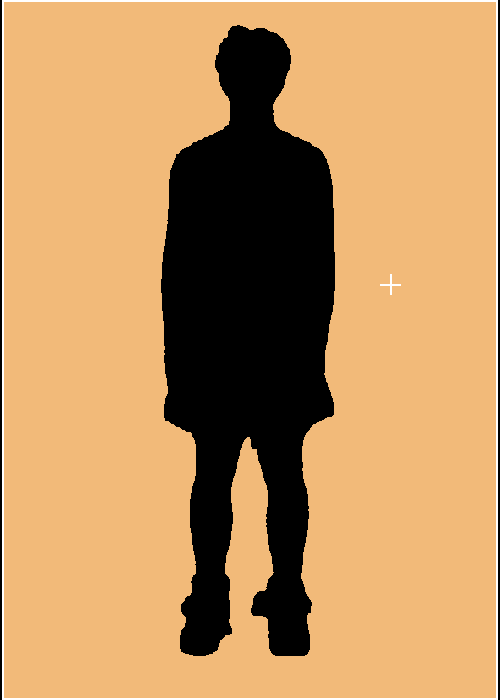
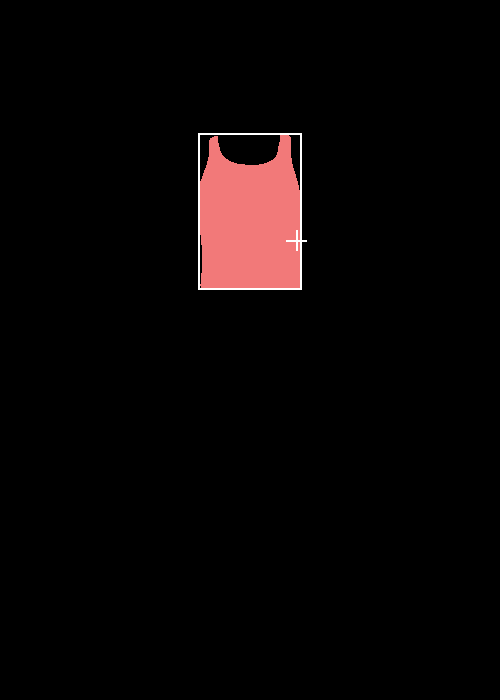
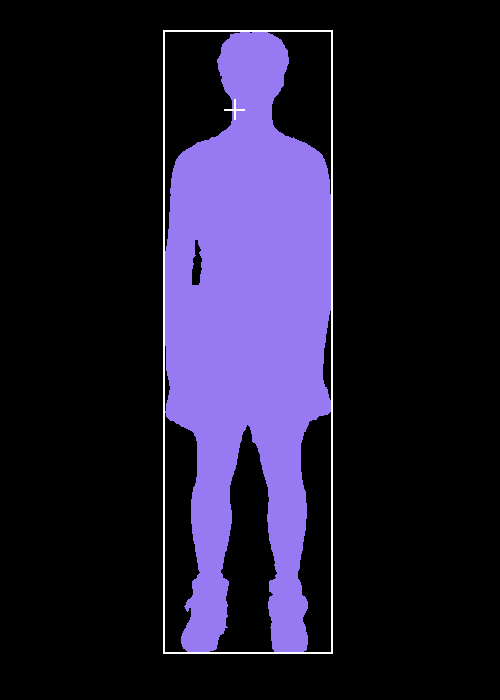
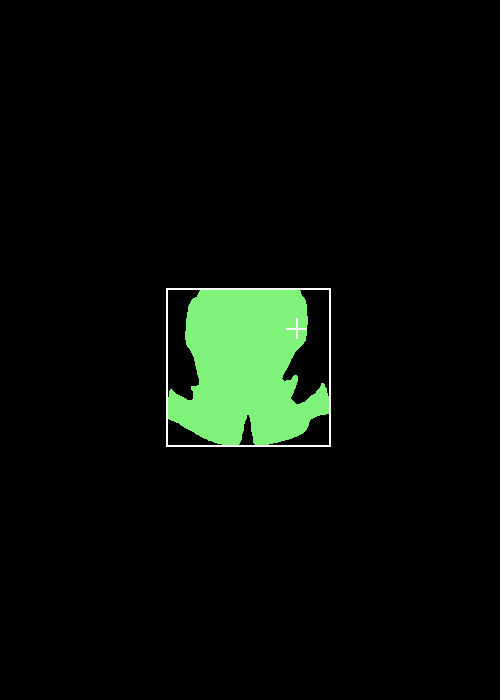
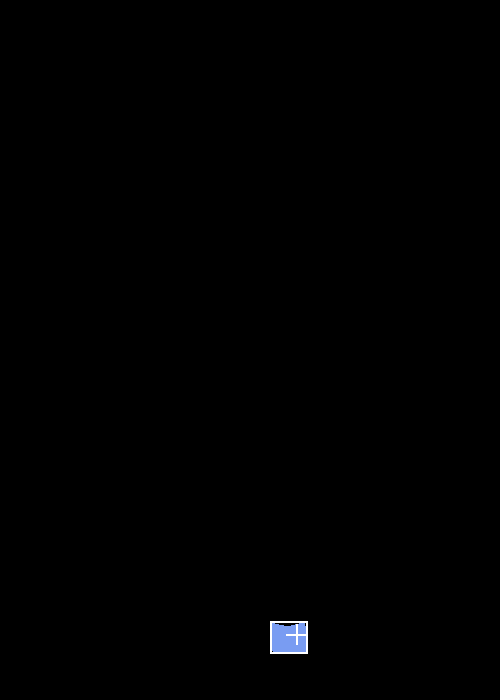
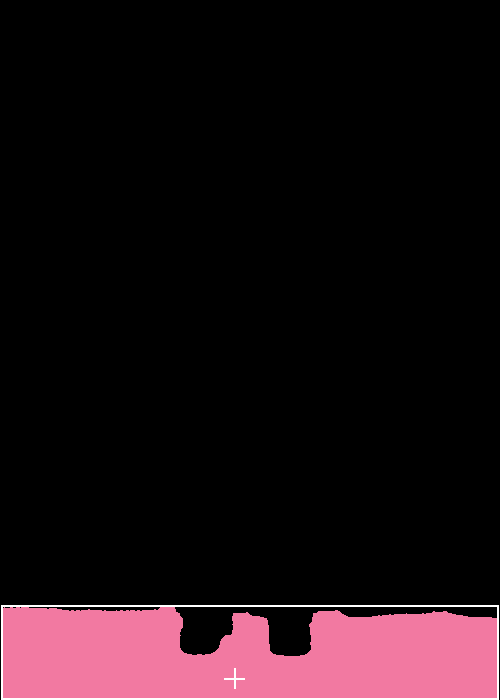
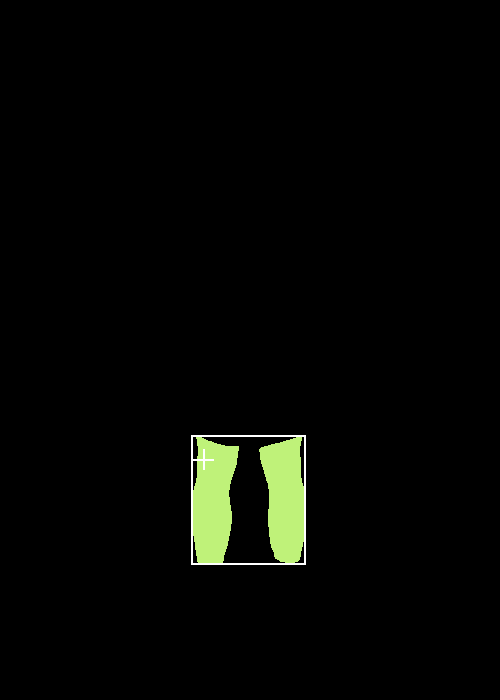
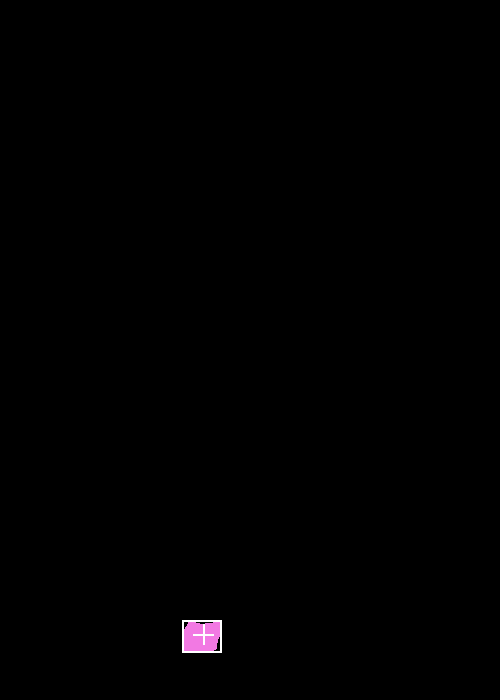
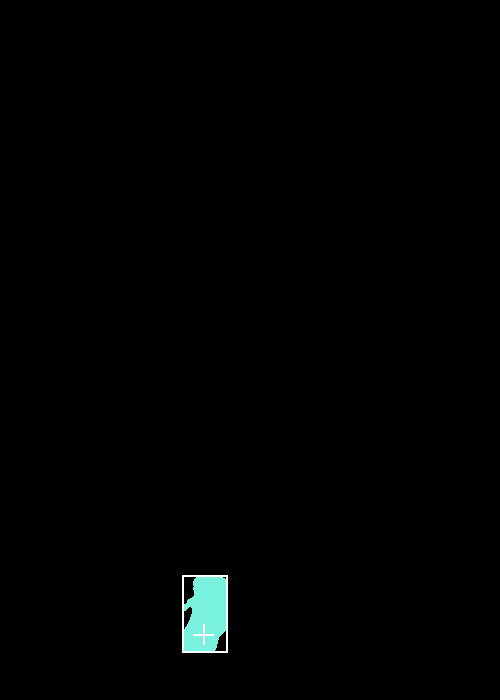
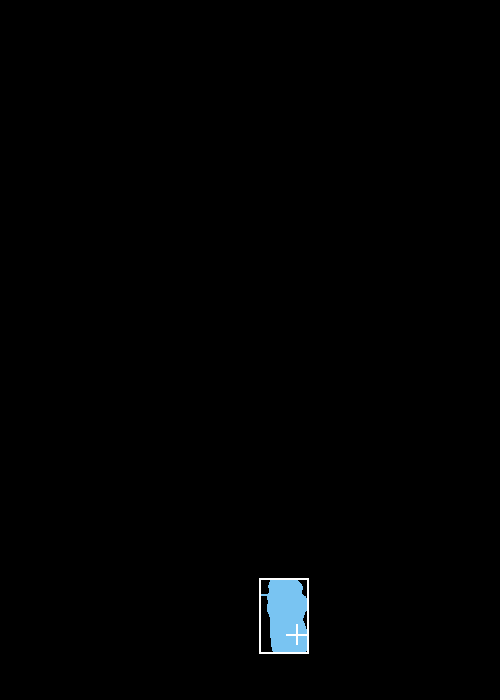

Processing image: C:\Users\ice\projects\iris\data\dev\nikolaj_storm\images\0571f3fdb99ff04665dc04b4f3367e0a_IMG_0654-500x700.jpg



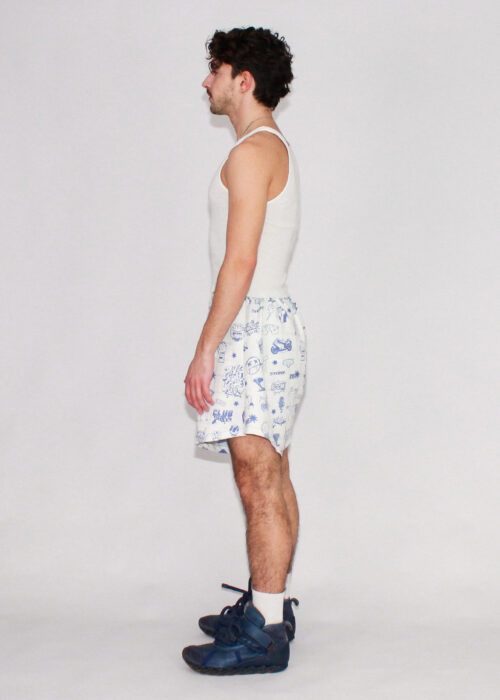
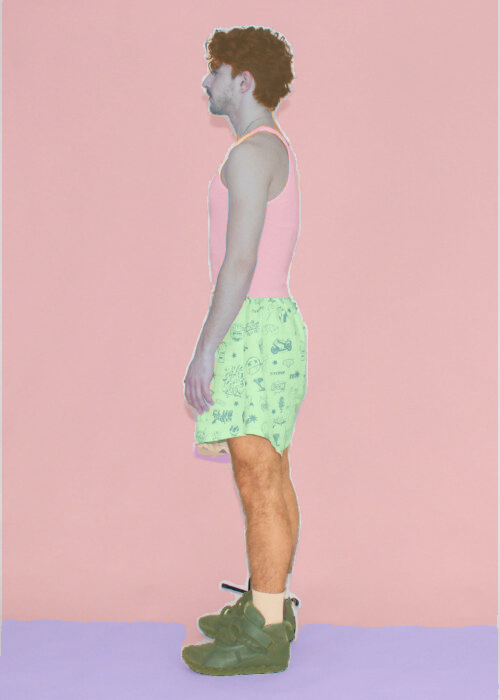
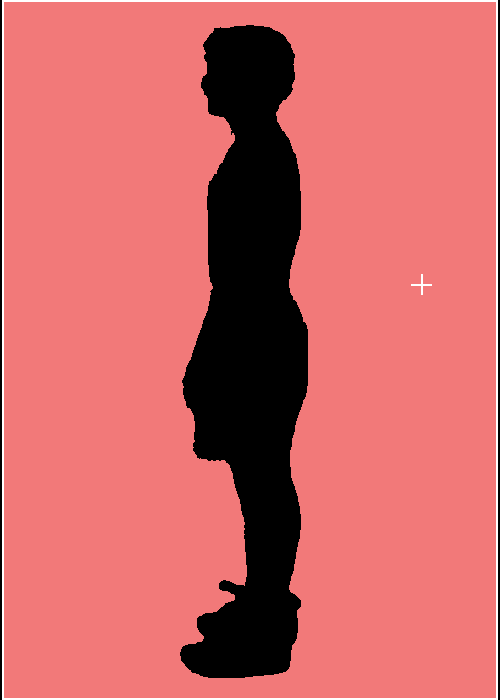
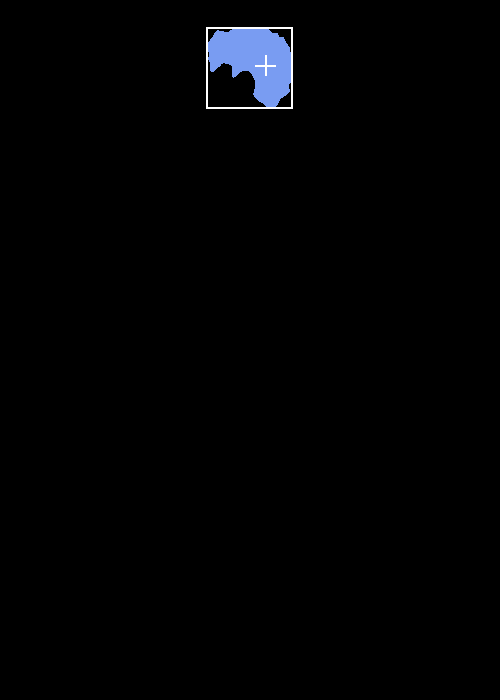
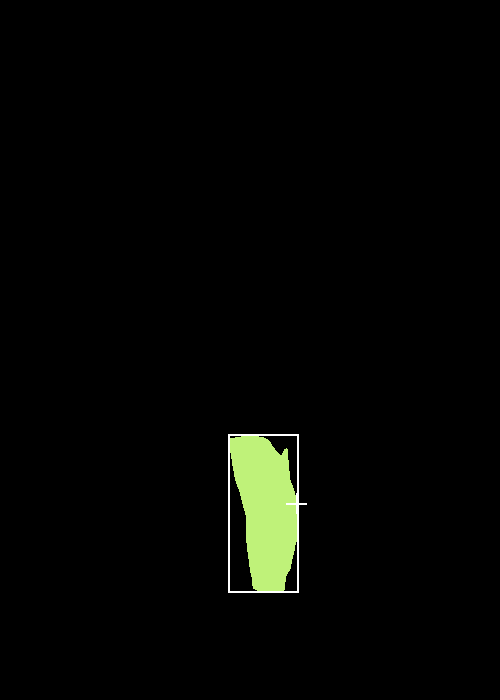
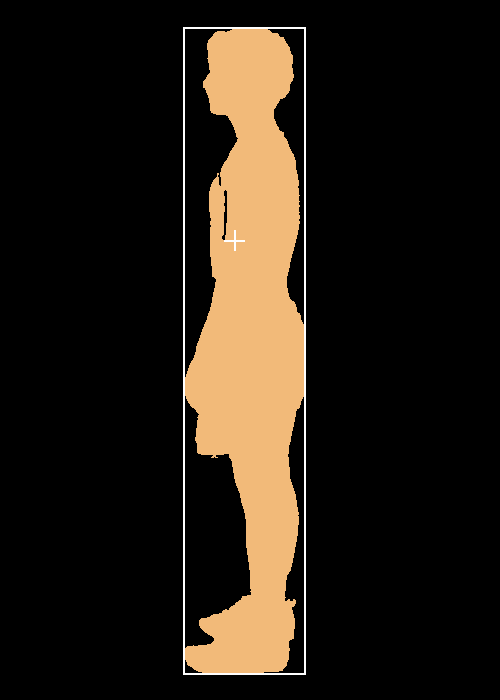
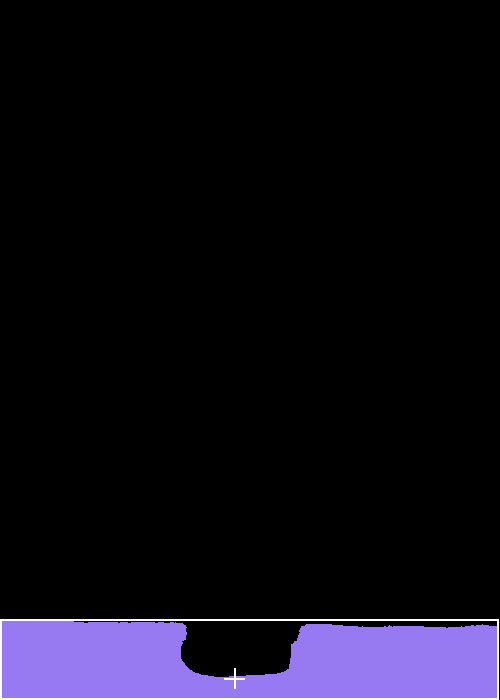
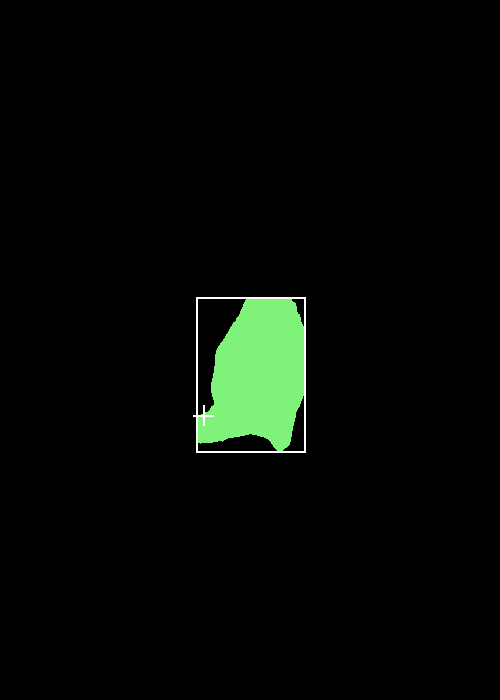
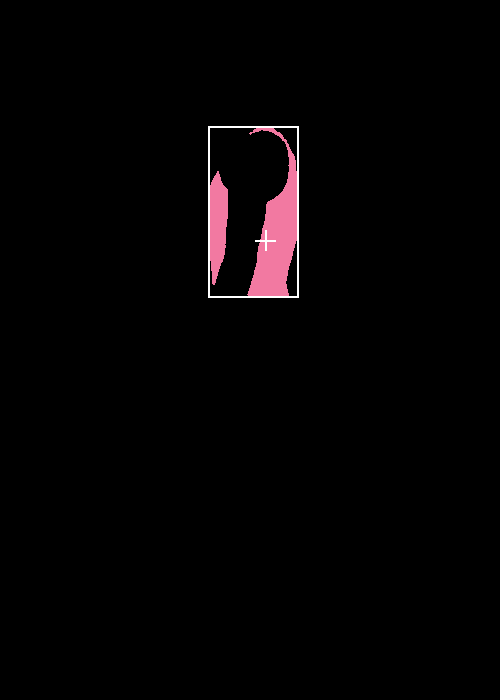
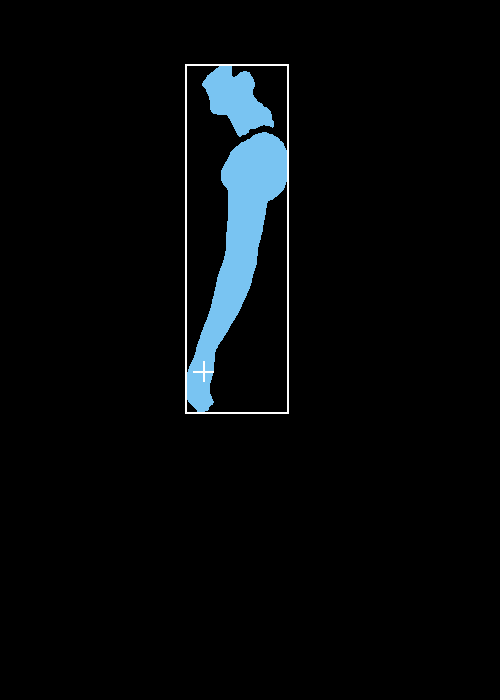
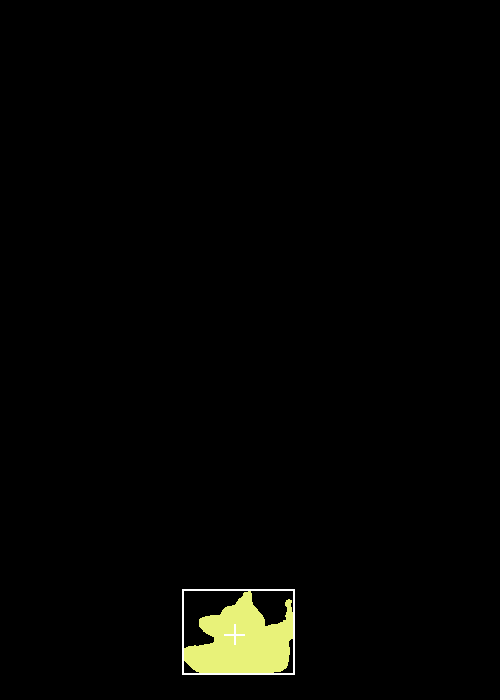
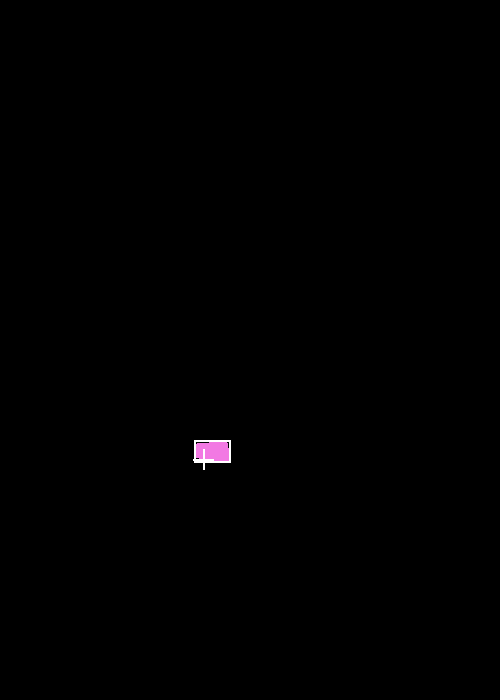
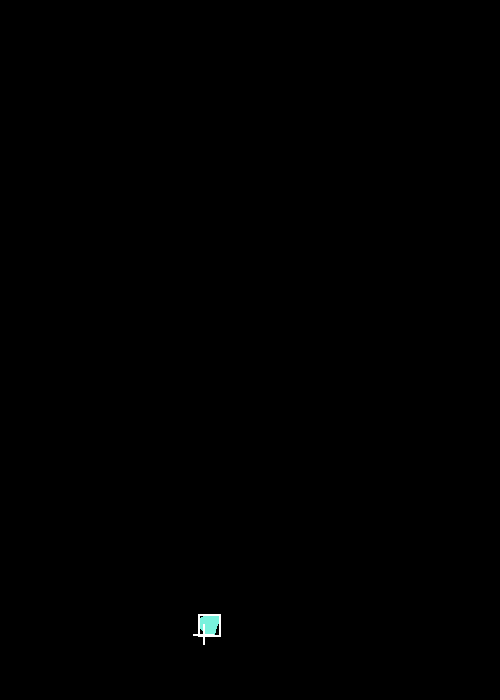

Processing image: C:\Users\ice\projects\iris\data\dev\nikolaj_storm\images\bb3ecb2e12fac67954ef0fb858ea1a2d_IMG_0656-500x700.jpg



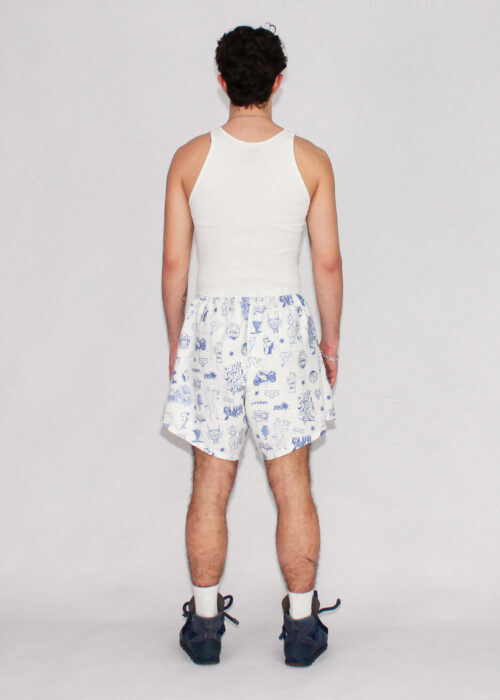
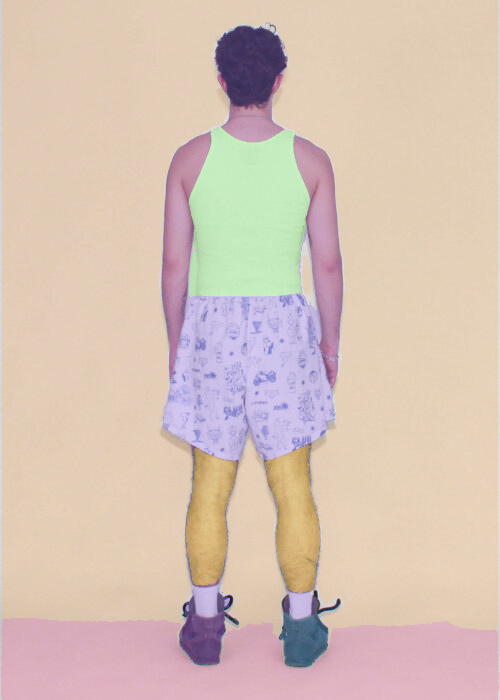
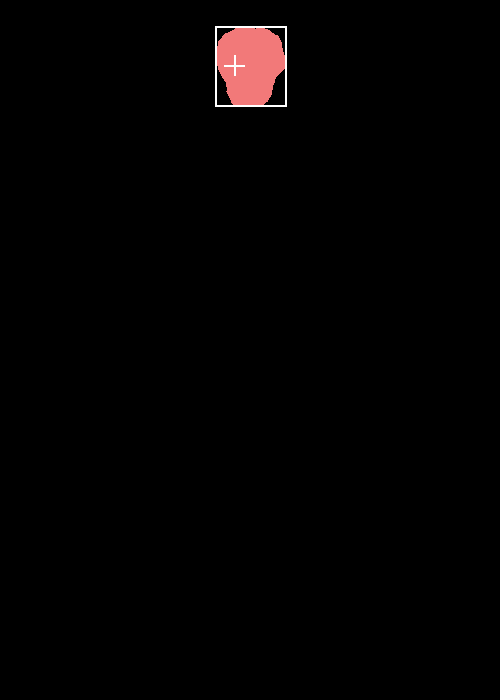
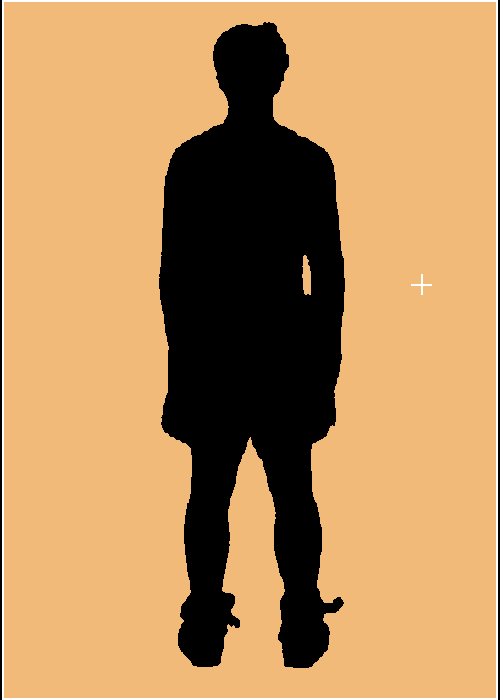
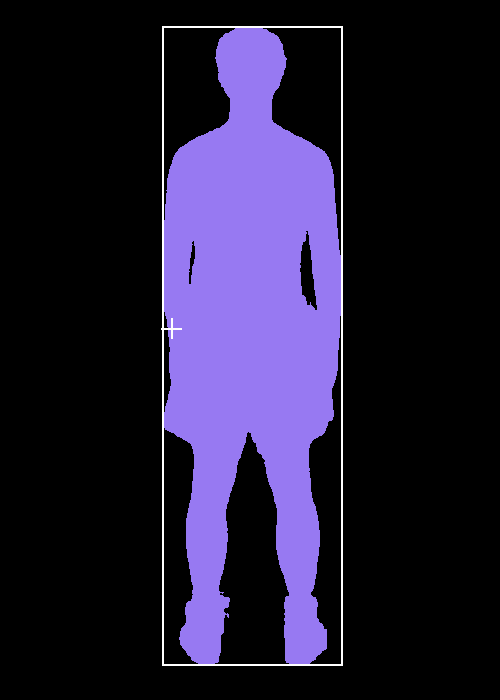
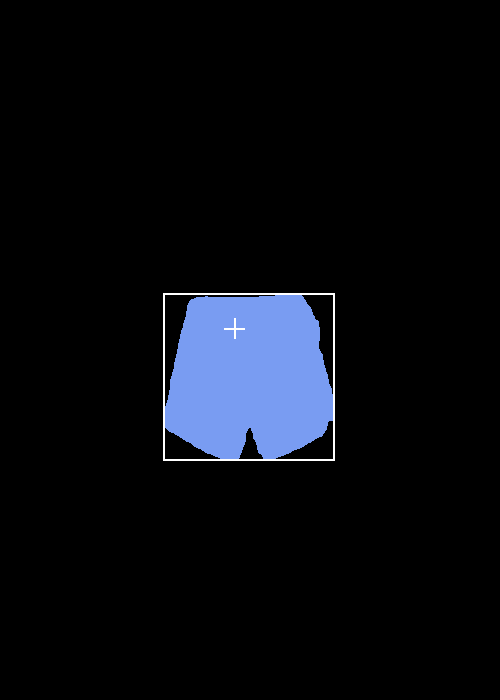
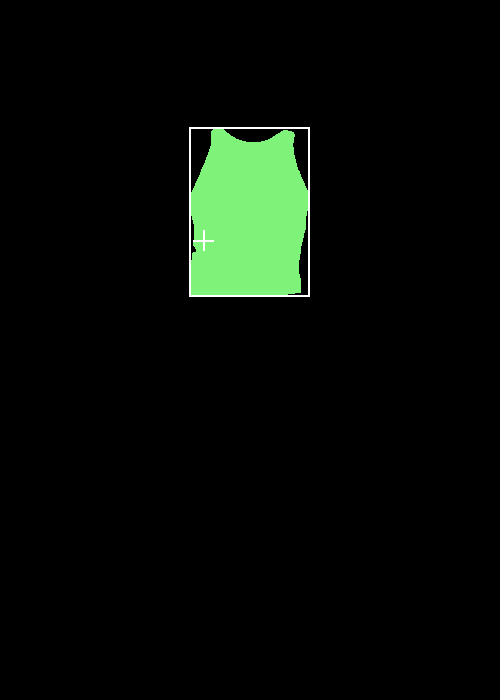
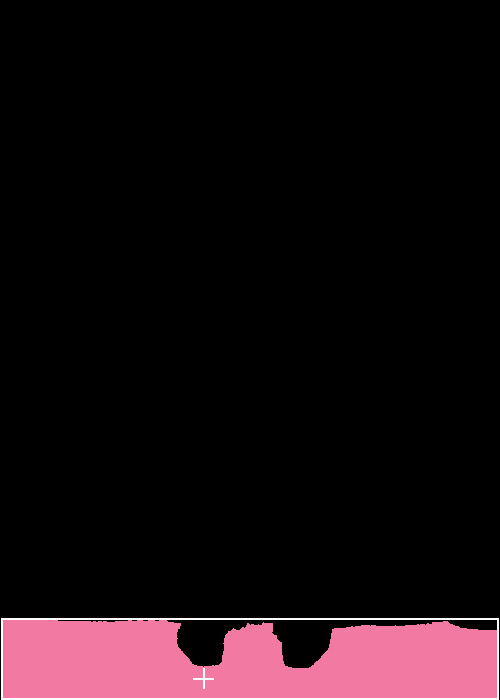
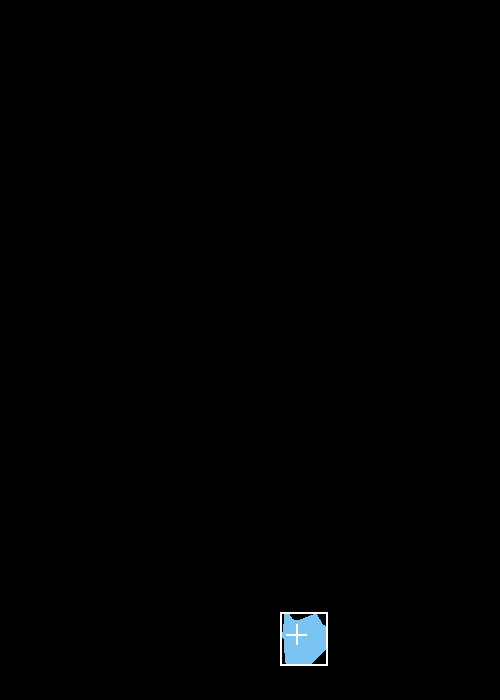
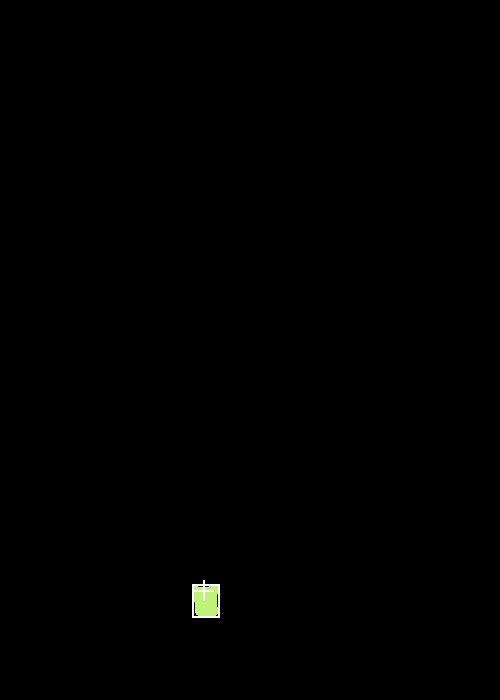
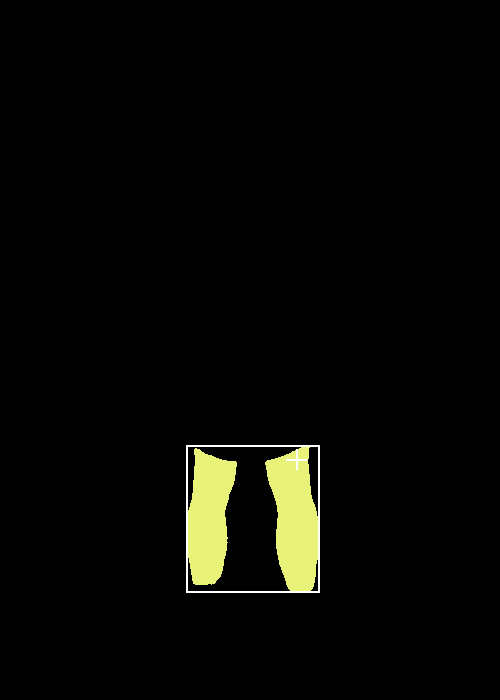
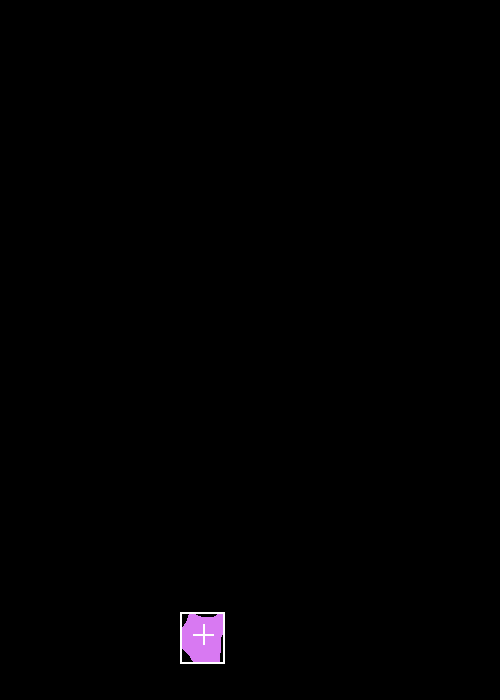
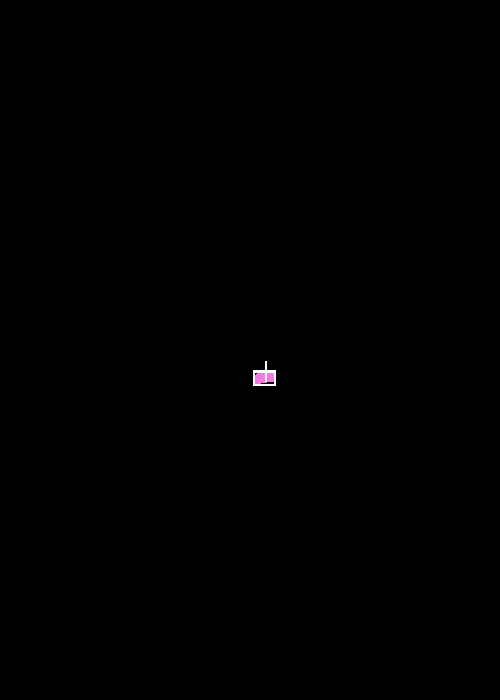
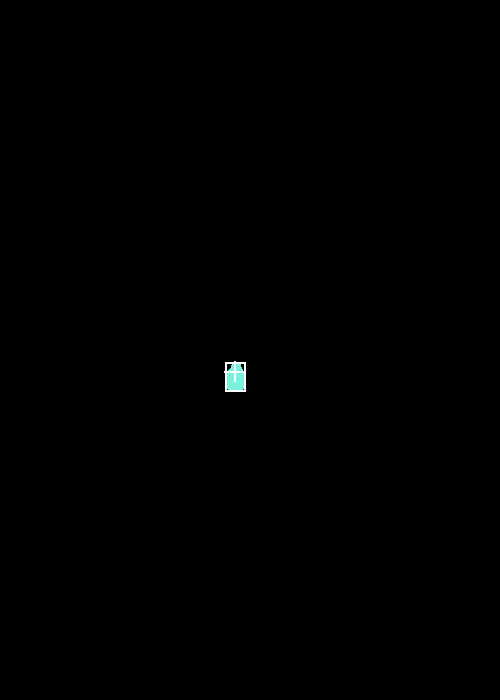

Processing image: C:\Users\ice\projects\iris\data\dev\nikolaj_storm\images\a073323a7c0f59dd03697952b98c773b_IMG_0725-500x750.jpg



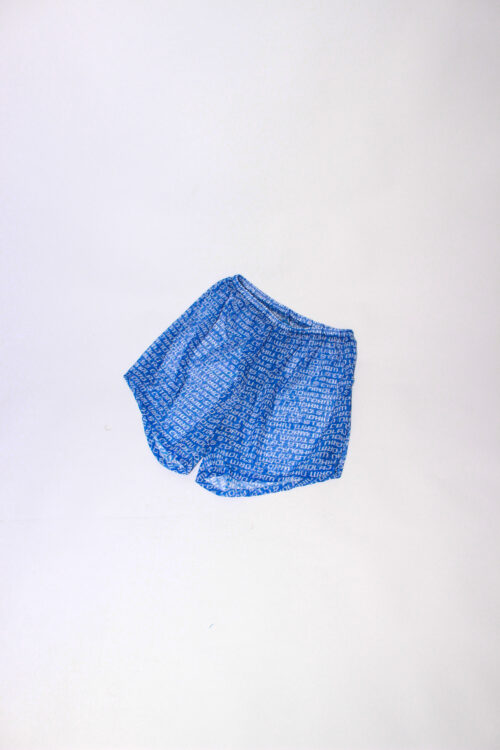
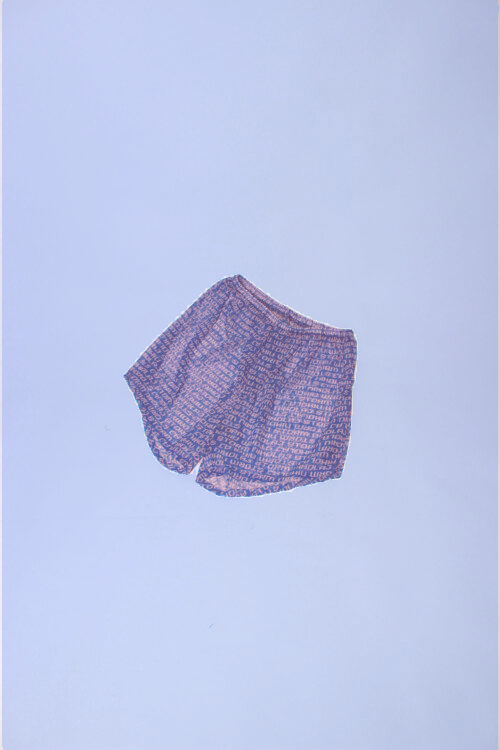
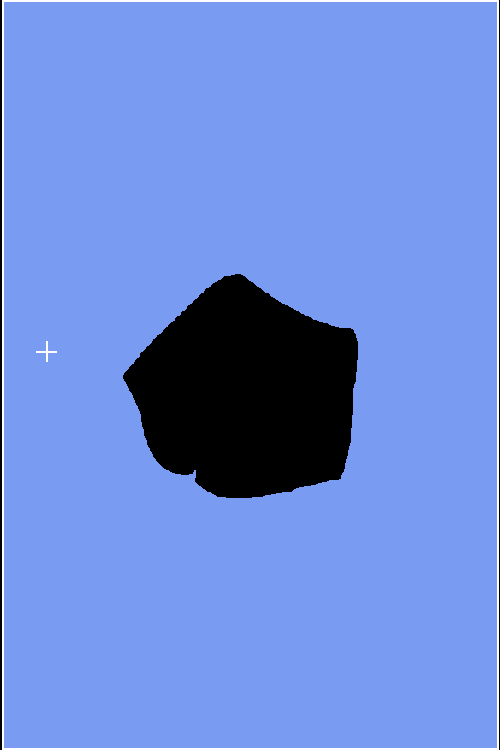
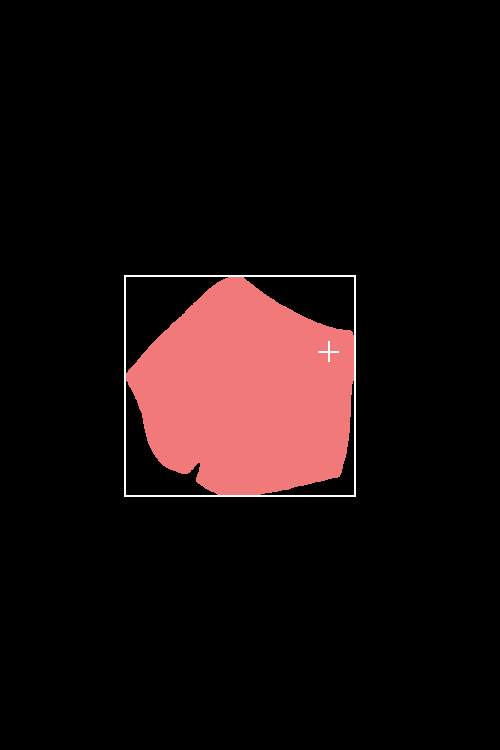

Processing image: C:\Users\ice\projects\iris\data\dev\nikolaj_storm\images\5f8a3e26947356ba91e1fb4d9eca8e3f_IMG_9954-500x700.jpg



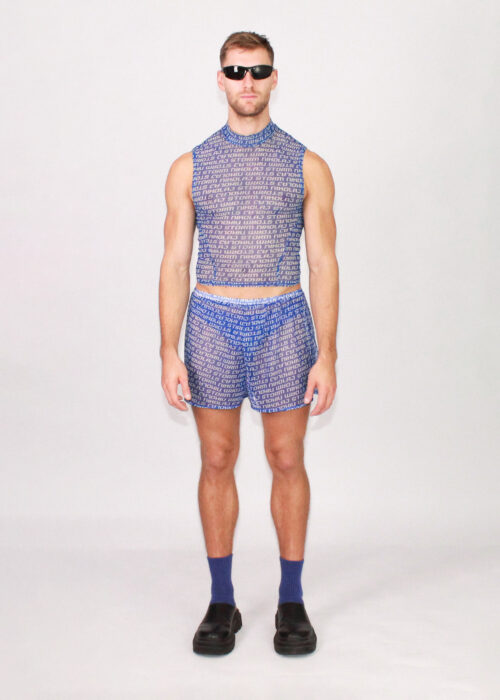
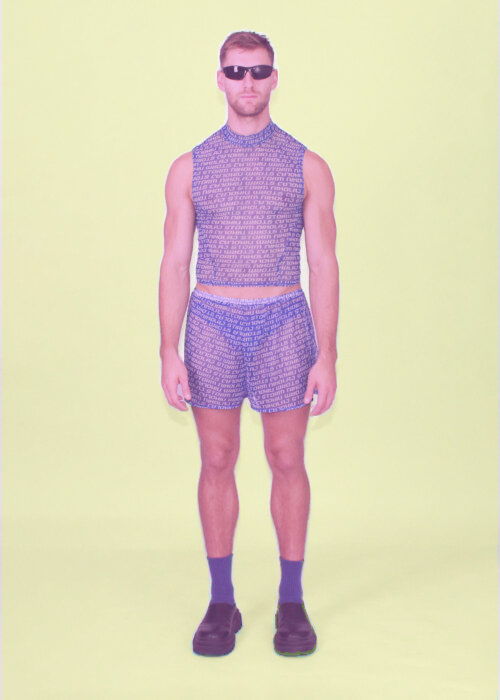
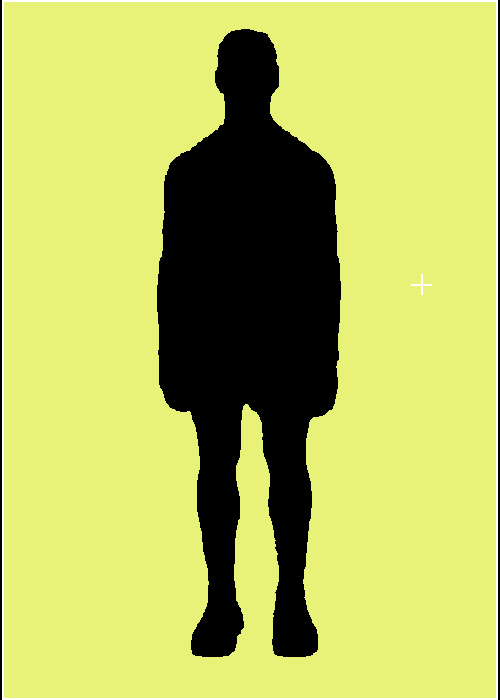
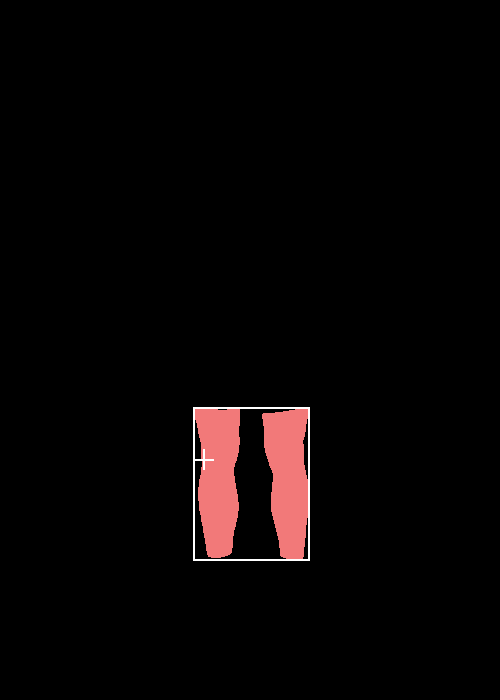
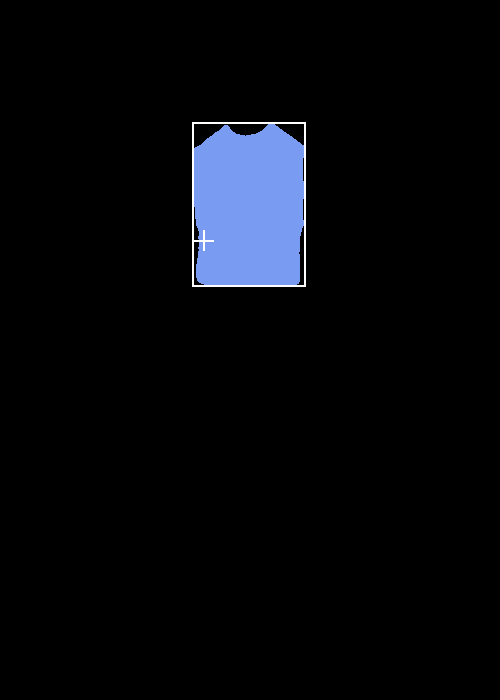
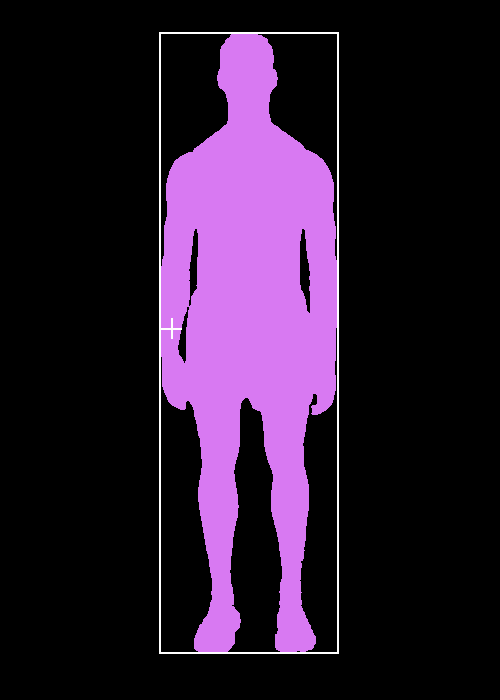
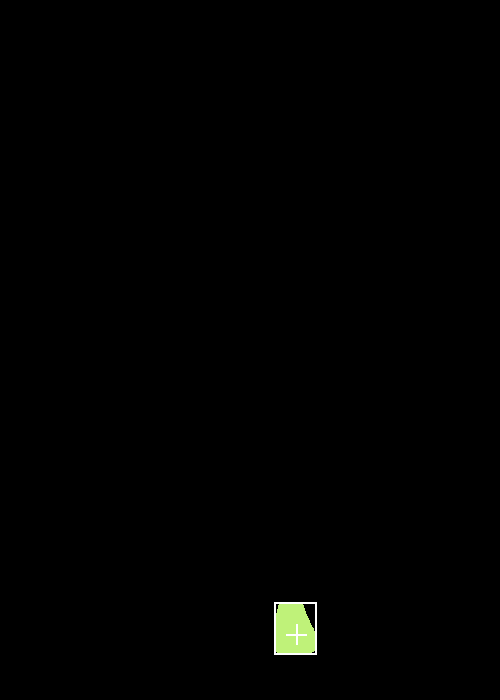
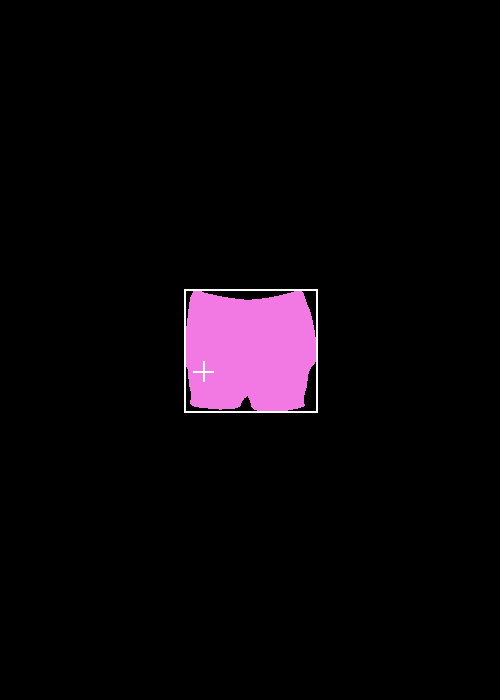
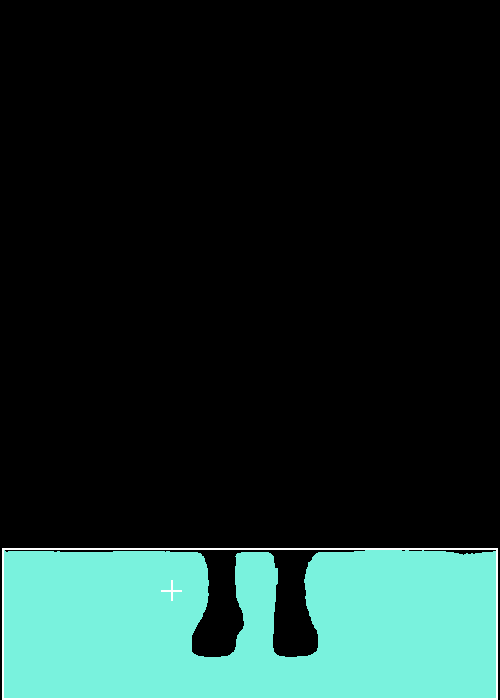
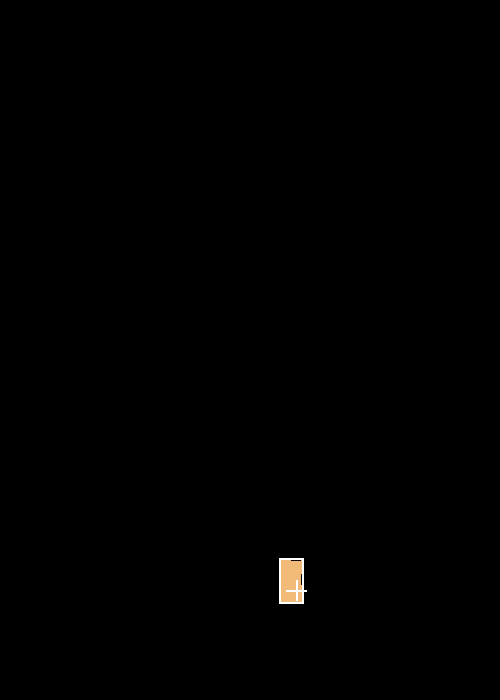
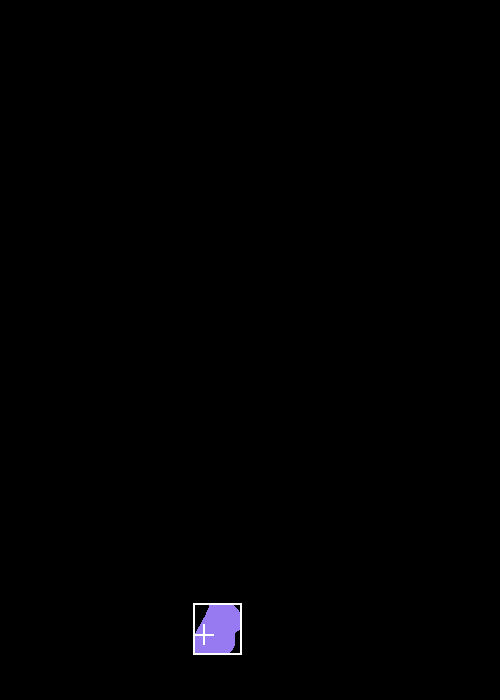
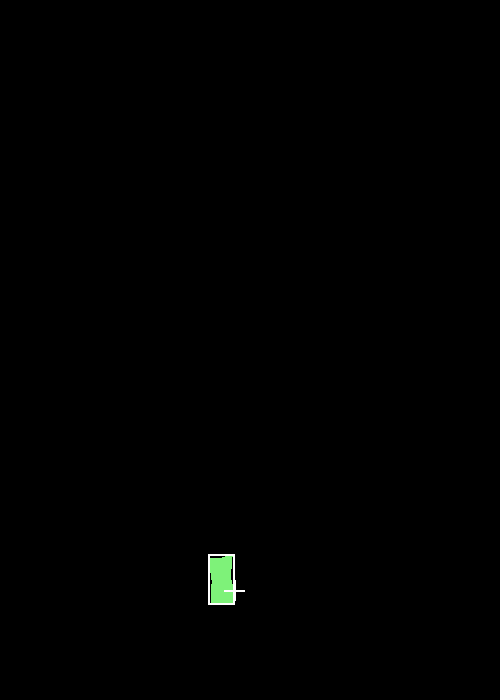
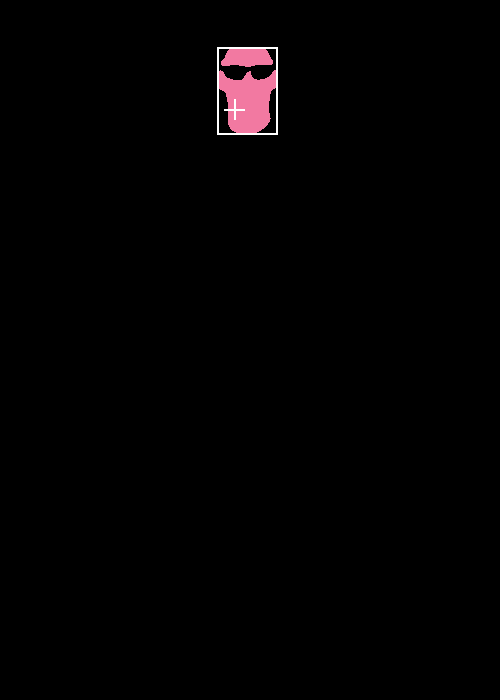
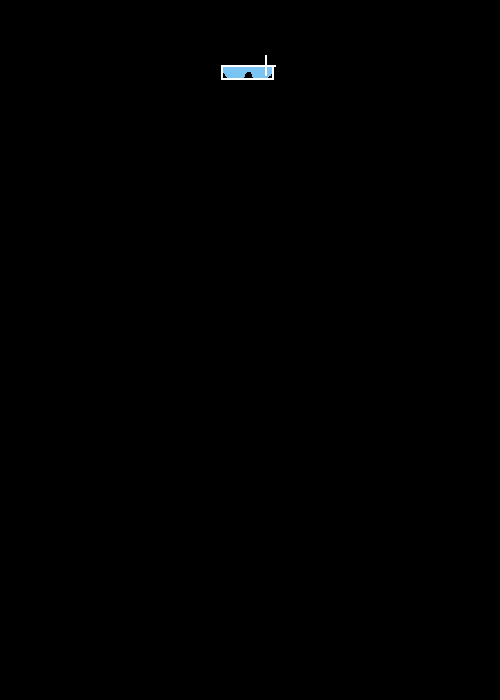

In [2]:
# Initialize configuration managers
segmentation_config = SegmentationPipelineConfigManager()
data_config = DataPipelineConfigManager()
shop_config = data_config.shop_configs["nikolaj_storm"]  # Select shop
mongodb_config = data_config.mongodb_config

# Create MongoDB manager
mongodb_manager = MongoDBManager(shop_config, mongodb_config)

# Create segmentation handler
segmentation_handler = SegmentationHandler(segmentation_config.sam2_config)

try:
    # Get image metadata collection
    image_metadata = mongodb_manager.get_collection(mongodb_config.image_metadata_collection)
    test_images = list(image_metadata.find().limit(5))  # Get 5 images for testing
    
    # Process each test image with progress bar
    for image_data in tqdm(test_images, desc='Processing images'):
        print(f"Processing image: {image_data['local_path']}")
        
        # Get the local image path
        if not image_data.get('local_path'):
            print("No local path found for this image")
            continue
            
        image_path = Path(image_data['local_path'])
        
        try:
            # Load image
            image = load_image(image_path, target_format="numpy", ensure_rgb=True)
            
            # Generate masks
            masks = segmentation_handler.segment_image(image)

            # Save segmentation metadata
            segmentation_handler.save_segmentation_metadata(
                image_data['image_hash'], 
                masks, 
                mongodb_manager
            )
            
            # Display results
            display_image_summary(
                mongodb_manager=mongodb_manager,
                image_hash=image_data['image_hash']
            )
            
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
        
finally:
    # Close MongoDB connection
    mongodb_manager.close()